In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

In [2]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
from functions import log, plot_top_words

In [5]:
df = pd.read_csv('files/select_files.txt', delimiter= '\t')

In [6]:
df = df[["PMID", "title", "references"]]

In [7]:
df["references"] = [ eval(x) for x in df["references"] ]

df

,PMID,title,references
0,12929205,The Transcriptome of the Intraerythrocytic Dev...,[Plasmodium falciparum: Analysis of transcribe...
1,12929206,DNA Analysis Indicates That Asian Elephants Ar...,[WHICHRUN (version 3.2): A computer program fo...
2,12975658,Drosophila Free-Running Rhythms Require Interc...,[A mutant Drosophila homolog of mammalian Cloc...
3,12975657,From Gene Trees to Organismal Phylogeny in Pro...,[Genome sequence of the endocellular obligate ...
4,14551903,A Functional Analysis of the Spacer of V(D)J R...,[Distinct roles of RAG1 and RAG2 in binding th...
...,...,...,...
3994,17925860,Large-Scale Mitochondrial DNA Analysis of the ...,"[Domesticated animals from early times., Goats..."
3995,17925881,"Endothelial Progenitor Cells, Cardiovascular R...",[Isolation of putative progenitor endothelial ...
3996,17925862,Ataxin-1 Fusion Partners Alter PolyQ Lethality...,[Protein aggregation and neurodegenerative dis...
3997,17925864,The Chemokine Receptor CXCR4 Strongly Promotes...,[Neuroblastoma: biological insights into a cli...


In [8]:
all_pmid = []
all_ref = []

def parseRefs(row):
    pmid = row['PMID']
    for i in row['references']:
        all_pmid.append(pmid)
        all_ref.append(i)

df.apply(parseRefs, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
3994    None
3995    None
3996    None
3997    None
3998    None
Length: 3999, dtype: object

In [9]:
del df

In [10]:
ref_df = pd.DataFrame(data = {'PMID' : all_pmid, 'ref' : all_ref})

In [13]:
ref_df = ref_df.dropna()

stop_words = set(stopwords.words('english'))

def parseGroupString(title):
    temp = re.sub(r'[^\w\s]', '', title)
    temp = temp.lower()
    temp = word_tokenize(temp)
    temp = [w for w in temp if not w in stop_words]
    temp = ' '.join([lemmatizer.lemmatize(w) for w in temp])
    return temp
                     
ref_df["ref"] = [ parseGroupString(x) for x in ref_df["ref"] ]

In [14]:
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words="english")
tfidf = tfidf_vect.fit_transform(ref_df["ref"].values.astype('U'))

In [15]:
n_top_words = 10 # for bar graph
n_topics = 5

In [16]:
nmf1 = NMF(
    n_components=n_topics,
    beta_loss="frobenius", #"frobenius"
    solver="cd",
    max_iter=1000,
    l1_ratio=0.5,
).fit(tfidf)

log(f'fitting {n_topics}')

c:\users\danny\miniconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


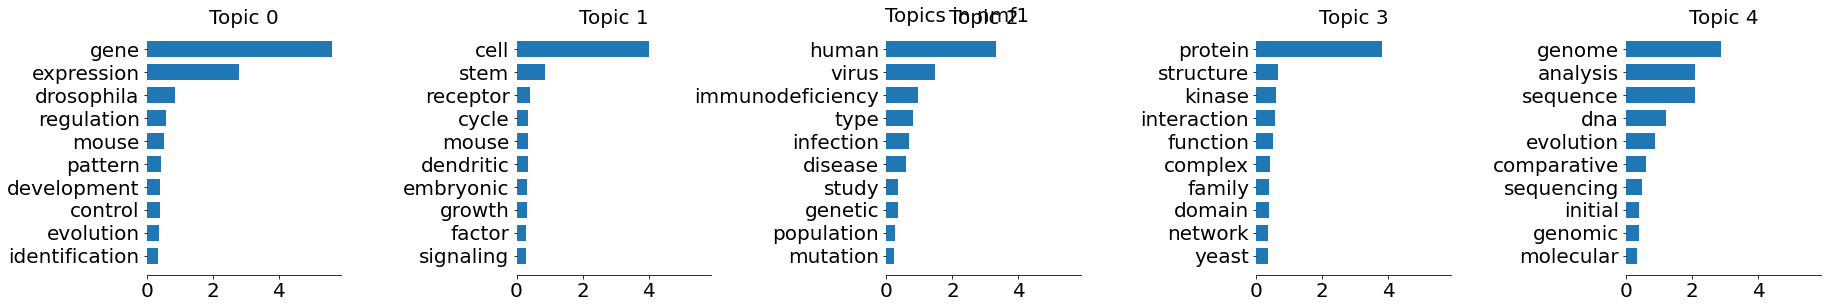

In [17]:
plot_top_words(
    nmf1, tfidf_vect.get_feature_names_out(), n_topics, n_top_words,"Topics in nmf1"
)

In [18]:
X_new = nmf1.transform(tfidf)
# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

In [19]:
ref_df["topic"] = predicted_topics

In [20]:
ref_df = ref_df[["PMID", 'topic']]

<AxesSubplot:ylabel='Frequency'>

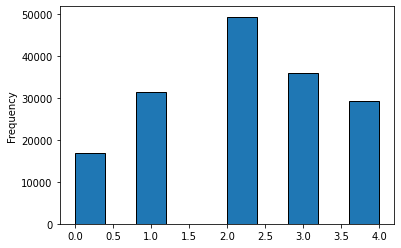

In [21]:
ref_df["topic"].plot(kind='hist', edgecolor='black')

In [22]:
ref_df = ref_df.groupby('PMID')['topic'].apply(list).reset_index(name='refTopics')

In [23]:
topicDict = {}

for i,topic in enumerate(nmf1.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1] # finds indeces of n top words
    top_features = [tfidf_vect.get_feature_names_out()[i] for i in top_features_ind] # gets the actual words
    topicDict[i] = top_features
    
print(topicDict)

{0: ['gene', 'expression', 'drosophila', 'regulation', 'mouse', 'pattern', 'development', 'control', 'evolution', 'identification'], 1: ['cell', 'stem', 'receptor', 'cycle', 'mouse', 'dendritic', 'embryonic', 'growth', 'factor', 'signaling'], 2: ['human', 'virus', 'immunodeficiency', 'type', 'infection', 'disease', 'study', 'genetic', 'population', 'mutation'], 3: ['protein', 'structure', 'kinase', 'interaction', 'function', 'complex', 'family', 'domain', 'network', 'yeast'], 4: ['genome', 'analysis', 'sequence', 'dna', 'evolution', 'comparative', 'sequencing', 'initial', 'genomic', 'molecular']}


In [24]:
with open(r'files/refTopicDict.pkl', 'wb') as f:
    pickle.dump(topicDict, f)
    
log(f'saving main word of ref topic to files/refTopicDict.pkl')

In [25]:
ref_df.to_csv(r'files/topics_refs.txt', sep='\t', index = False)
log(f'Ran topics_abstract.ipynb succesfully')